# Week-03 — Baseline CNNs: Data Loading & Environment Setup

**Goal of this notebook.**
Establish the reproducible foundation for **Chapter 2** by:
- Setting up the Python / PyTorch environment (Apple Silicon **MPS** on M-series).
- Recording exact package versions (for reproducibility).
- Creating project folders for data and outputs.
- (Next cells) Loading three **MedMNIST** subsets — **ChestMNIST**, **PneumoniaMNIST**, **BreastMNIST** — to run baseline CNNs (ResNet-18).
- Ensuring this notebook is **explainable** with narrative + figures.

**Why start here?**
Chapter 2 asks: *What is baseline CNN performance and what are its limitations under small, “thick” data conditions?*
A clean, deterministic setup ensures that any performance we report (Accuracy, Sensitivity/Specificity, F1, ROC-AUC, PR-AUC, Calibration) is repeatable. The limitations we find here will **motivate Chapter 3** (few-shot with clinical heuristics) and **Chapter 4** (augmentation / ROI).

**Deliverables from this notebook (over Week-03):**
- Verified environment (MPS enabled), package versions snapshot.
- Dataset loaders & sanity checks (sizes, class balance, sample grids).
- Baseline **ResNet-18** training/evaluation per dataset.
- Saved figures: confusion matrices, ROC/PR curves, 2–3 Grad-CAMs per dataset.
- A concise results table to copy into **Chapter 2** (proposal).
-
## Results & Model Saving Policy

- **Figures & Plots**: All generated plots (confusion matrices, ROC/PR curves, Grad-CAMs) will be saved in
  `prototyping/week-03/results/`.

- **Model Checkpoints**: After training, ResNet-18 weights will be saved as
  `prototyping/week-03/results/<dataset>_resnet18.pth`.
  These can be reloaded later to avoid retraining.

- **Requirements Snapshot**: Saved as `requirements-week-03.txt` to ensure reproducibility.

- **No Logs**: Training logs, intermediate run folders, and raw temporary artifacts will **not be kept** at all.
  Only final outputs (figures + model checkpoints) are preserved.



## Step 1: Environment & Results Directory Setup

In [43]:
import os, sys, platform, random
from pathlib import Path
from datetime import datetime
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

if hasattr(torch.backends, "cudnn"):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device selection
def pick_device():
    if torch.cuda.is_available():
        return torch.device("cuda"), f"CUDA: {torch.cuda.get_device_name(0)}"
    if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
        return torch.device("mps"), "Apple Silicon MPS"
    return torch.device("cpu"), "CPU"

DEVICE, DEVICE_NAME = pick_device()

# Assume notebook lives in: MSC-Project/prototyping/week-03/
PROJECT_ROOT = Path.cwd().resolve().parents[1]  # go up to MSC-Project
RESULTS_DIR  = PROJECT_ROOT / "prototyping" / "week-03" / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root : {PROJECT_ROOT}")
print(f"Results dir  : {RESULTS_DIR}")


print(f"Project root : {PROJECT_ROOT}")
print(f"Results dir  : {RESULTS_DIR}")


# Requirements snapshot
requirements_path = PROJECT_ROOT / "prototyping" / "week-03" / "requirements-week-03.txt"
with open(requirements_path, "w") as f:
    f.write(f"python=={sys.version.split()[0]}\n")
    f.write(f"torch=={torch.__version__}\n")
    f.write(f"matplotlib=={matplotlib.__version__}\n")
    f.write(f"numpy=={np.__version__}\n")

print("=== Week-03 Environment Summary ===")
print(f"python       : {sys.version.split()[0]}")
print(f"platform     : {platform.platform()}")
print(f"device       : {DEVICE_NAME}")
print(f"requirements : {requirements_path}")
print(f"results dir  : {RESULTS_DIR}")


Project root : /Users/ali/Documents/MSC-Project/Project
Results dir  : /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results
Project root : /Users/ali/Documents/MSC-Project/Project
Results dir  : /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results
=== Week-03 Environment Summary ===
python       : 3.11.9
platform     : macOS-26.0-arm64-arm-64bit
device       : Apple Silicon MPS
requirements : /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/requirements-week-03.txt
results dir  : /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results


## Step 2: Utility Functions

In [44]:
# Utility functions for saving results

def save_figure(fig, filename: str):
    """Save a matplotlib figure into the results directory."""
    out_path = RESULTS_DIR / filename
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    print(f"[saved figure] {out_path}")

def save_model(model: torch.nn.Module, filename: str):
    """Save a PyTorch model checkpoint into the results directory."""
    out_path = RESULTS_DIR / filename
    torch.save(model.state_dict(), out_path)
    print(f"[saved model] {out_path}")

def load_model(model_class, filename: str, device=DEVICE):
    """Reload a saved PyTorch model checkpoint."""
    out_path = RESULTS_DIR / filename
    model = model_class()
    model.load_state_dict(torch.load(out_path, map_location=device))
    model.to(device)
    print(f"[loaded model] {out_path}")
    return model

## Step 3: Load MedMNIST Subsets (ChestMNIST, PneumoniaMNIST, BreastMNIST)

We now load three biomedical imaging subsets from **MedMNIST v2**:

- **ChestMNIST** → multi-label chest X-rays (14 disease labels).
- **PneumoniaMNIST** → binary chest X-rays (pneumonia vs. normal).
- **BreastMNIST** → binary breast ultrasound images (benign vs. malignant).

For each dataset, we will:
1. Print dataset size and label information.
2. Show and save a random sample grid to the `results/` directory.

ChestMNIST      | split=train | size=78468 | shape=(1, 28, 28)
PneumoniaMNIST  | split=train | size=4708 | shape=(1, 28, 28)
BreastMNIST     | split=train | size=546 | shape=(1, 28, 28)
[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/chestmnist_samples.png


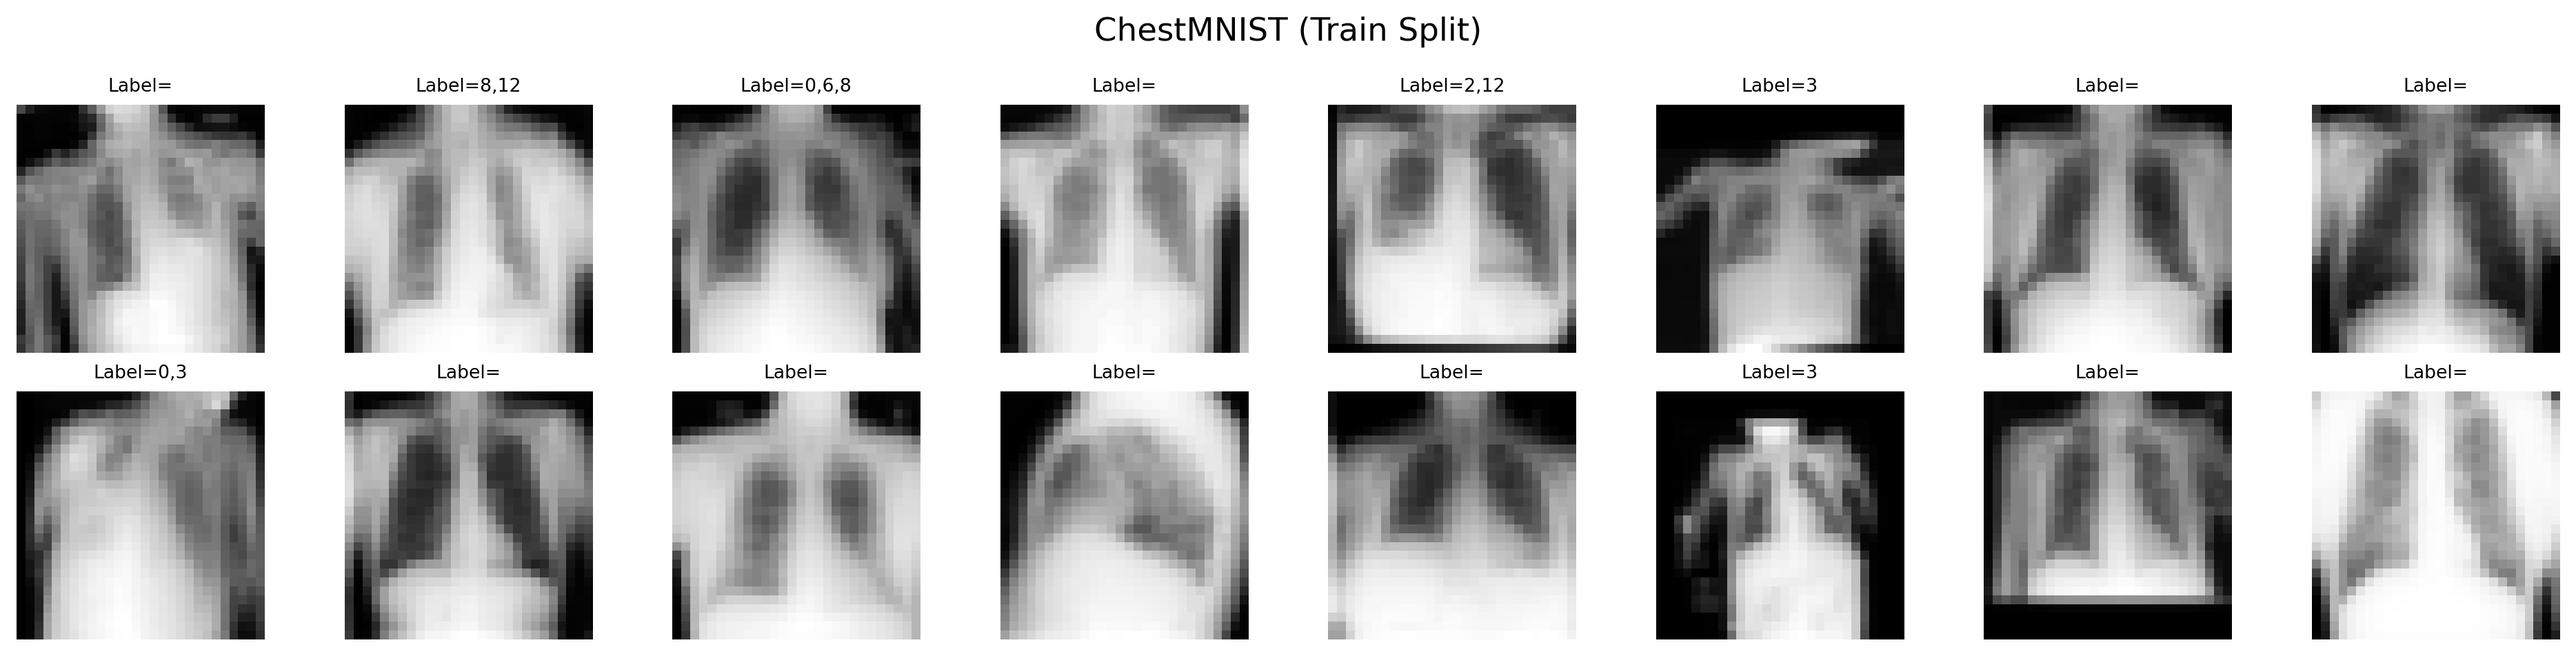

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/pneumoniamnist_samples.png


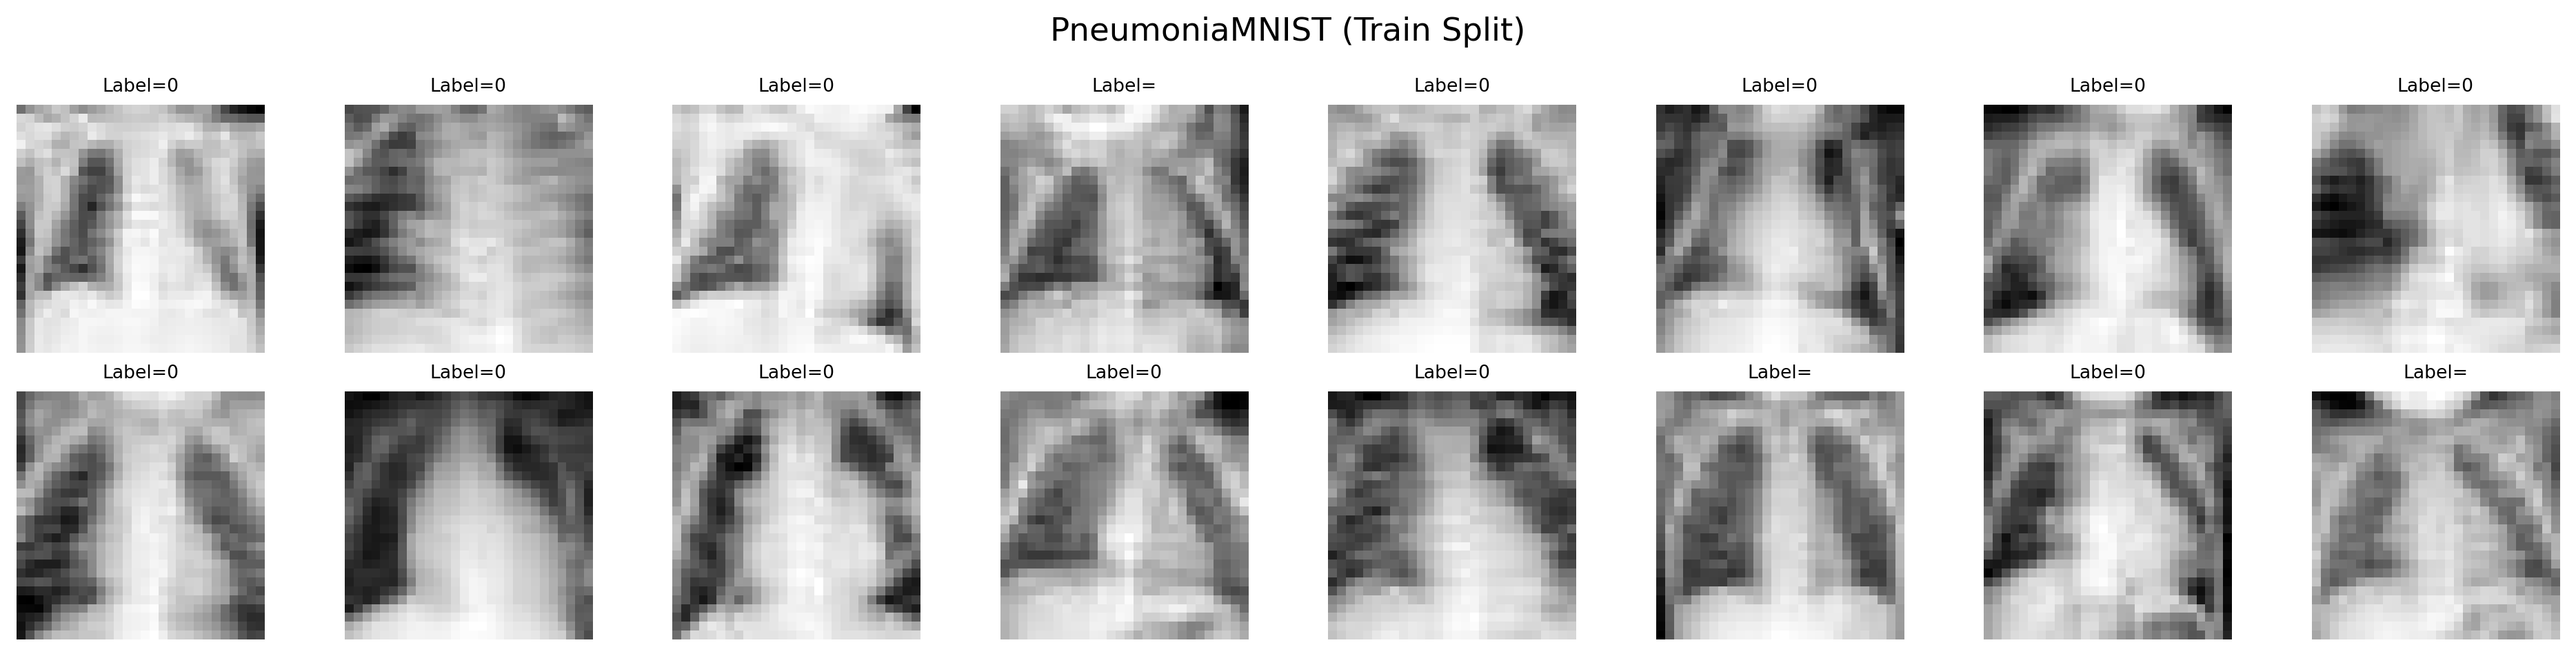

[saved figure] /Users/ali/Documents/MSC-Project/Project/prototyping/week-03/results/breastmnist_samples.png


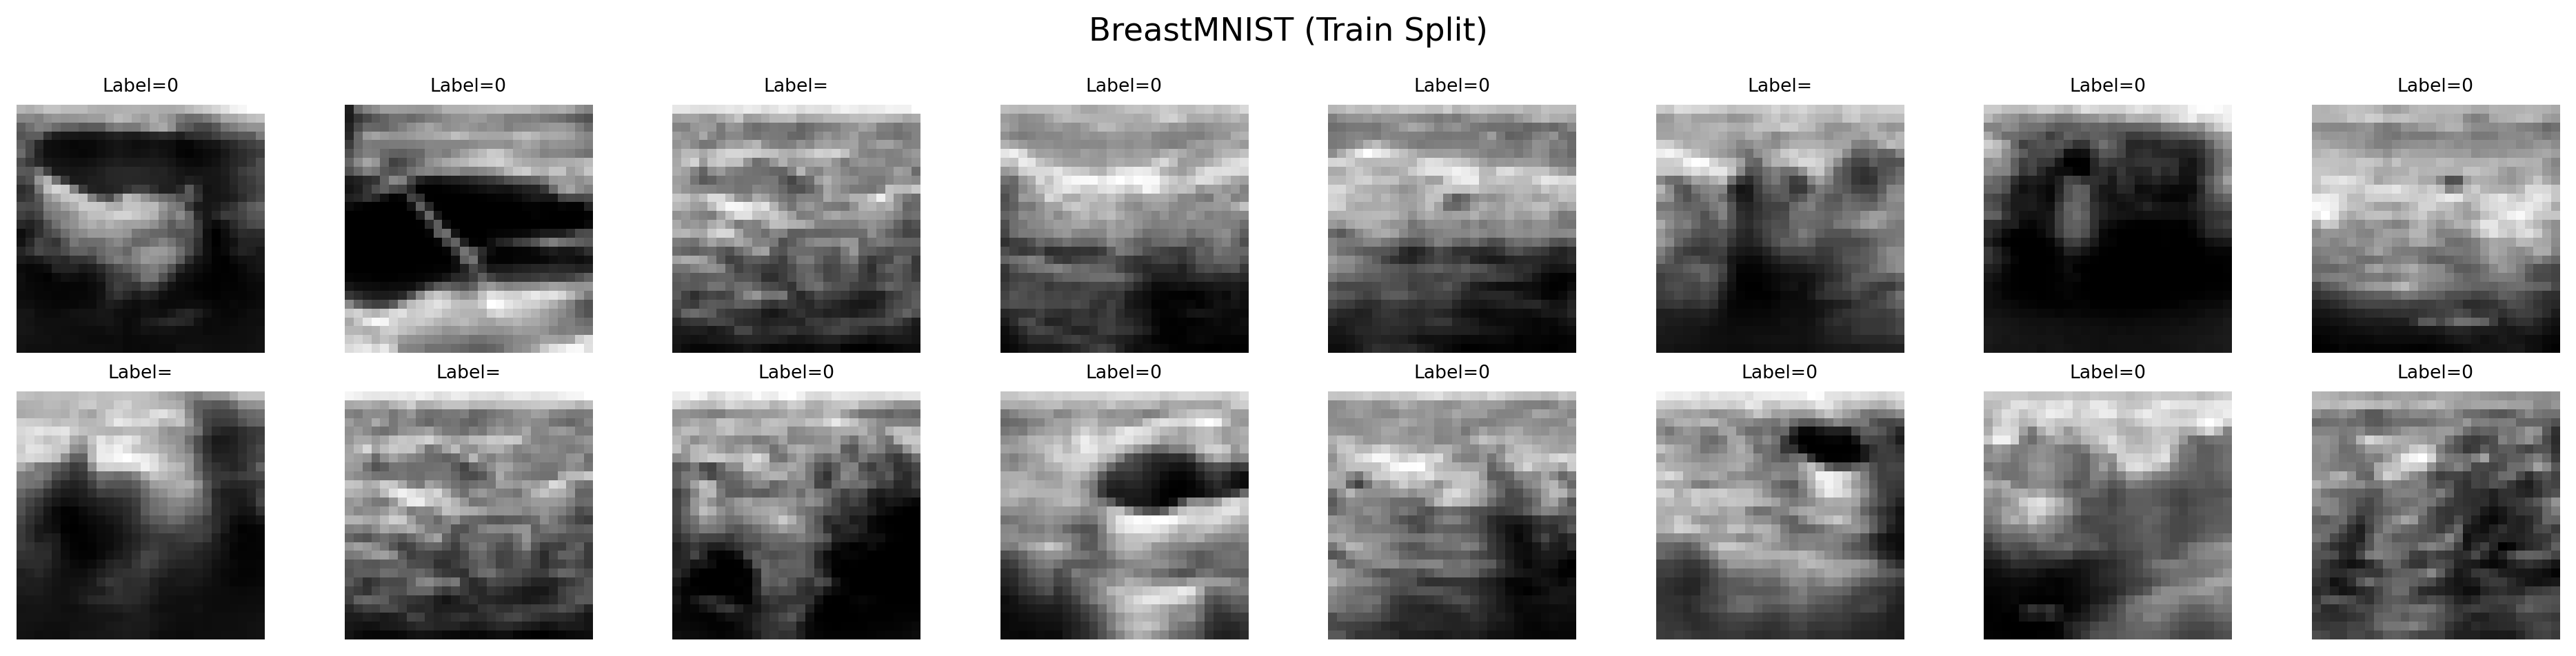

In [45]:
from medmnist import ChestMNIST, PneumoniaMNIST, BreastMNIST
from torchvision import transforms
import matplotlib.pyplot as plt

# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Ensure dataset root directory exists
DATA_DIR = PROJECT_ROOT / "data" / "external" / "medmnist"
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Load datasets (train splits for preview)
datasets = {
    "ChestMNIST": ChestMNIST(split="train", download=True, transform=transform, root=DATA_DIR),
    "PneumoniaMNIST": PneumoniaMNIST(split="train", download=True, transform=transform, root=DATA_DIR),
    "BreastMNIST": BreastMNIST(split="train", download=True, transform=transform, root=DATA_DIR)
}


# Describe datasets
for name, ds in datasets.items():
    print(f"{name:<15} | split={ds.split} | size={len(ds)} | shape={tuple(ds[0][0].shape)}")

# Visualization
def show_and_save_samples(ds, name, n=16, cols=8):
    idxs = np.random.choice(len(ds), n, replace=False)
    fig, axes = plt.subplots(n // cols, cols, figsize=(cols * 2, (n // cols) * 2))

    for ax, idx in zip(axes.flat, idxs):
        img, label = ds[idx]
        img_np = img.squeeze().numpy()

        ax.imshow(img_np, cmap="gray")

        # Handle label: scalar vs multi-label array
        if np.ndim(label) == 0 or (isinstance(label, (np.integer, int))):
            label_str = str(int(label))
        else:
            # For multi-label: show indices of "1"
            label_str = ",".join([str(i) for i, v in enumerate(label) if v == 1])

        ax.set_title(f"Label={label_str}", fontsize=8)
        ax.axis("off")

    plt.suptitle(f"{name} (Train Split)", fontsize=14)
    plt.tight_layout()
    save_figure(fig, f"{name.lower()}_samples.png")
    plt.show()

for name, ds in datasets.items():
    show_and_save_samples(ds, name)